In [191]:
import pandas as pd
import requests
from io import StringIO
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

RS = 42

In [192]:
def get_csv_df(csv_name):
    url = f"https://storage.googleapis.com/nba_award_predictor/nba_data/{csv_name}"

    r = requests.get(url)
    r.raise_for_status()

    csv_text = r.content.decode('utf-8')
    df = pd.read_csv(StringIO(csv_text))
    return df

# Data Extraction and Preparation

In [193]:
total = get_csv_df("features-overall-weekly.csv")

In [194]:
# Target/y label, 1 if player is winner, 0 otherwise
y = total['won_player_of_the_week']

In [195]:
"""
full_name, player_id: not features
pow_player_id, player_of_the_week, won_player_of_week: target labels (y data)
all_star_this_season, mvp_this_season, all_nba_first_team_this_season, all_nba_second_team_this_season, all_nba_third_team_this_season: "future data", not determined until end of the season
week_start, pow_conference: redundant, we have season, week, conference
is_win_vs_over_500, opponent_has_all_nba: these were encoders for game entries, our rows are week entries

ask about breakout_score, z_... vs. team_... (is z=z-score and is team features also normalized?)
"""
X = total.drop(columns=['full_name', 'player_id', 'pow_player_id', 'player_of_the_week', 'won_player_of_the_week', 'all_star_this_season', 'mvp_this_season',
 'all_nba_first_team_this_season', 'all_nba_second_team_this_season', 'all_nba_third_team_this_season', 'week_start', 'pow_conference',
 'is_win_vs_over_500', 'opponent_has_all_nba'])

In [196]:
# Do not need to hot encode category features for lightgbm, instead cast as category type
cat_cols = ['team', 'conference']
for c in cat_cols:
    X[c] = X[c].astype("category")

In [197]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233365 entries, 0 to 233364
Data columns (total 56 columns):
 #   Column                            Non-Null Count   Dtype   
---  ------                            --------------   -----   
 0   team                              233365 non-null  category
 1   season                            233365 non-null  int64   
 2   week                              233365 non-null  int64   
 3   conference                        233365 non-null  category
 4   games_played_this_week            233365 non-null  int64   
 5   numMinutes                        233365 non-null  float64 
 6   points                            233365 non-null  float64 
 7   assists                           233365 non-null  float64 
 8   blocks                            233365 non-null  float64 
 9   steals                            233365 non-null  float64 
 10  reboundsTotal                     233365 non-null  float64 
 11  reboundsDefensive                 23336

In [198]:
# Double check for null values
X.isnull().sum()

team                                0
season                              0
week                                0
conference                          0
games_played_this_week              0
numMinutes                          0
points                              0
assists                             0
blocks                              0
steals                              0
reboundsTotal                       0
reboundsDefensive                   0
reboundsOffensive                   0
fieldGoalsAttempted                 0
fieldGoalsMade                      0
threePointersAttempted              0
threePointersMade                   0
freeThrowsAttempted                 0
freeThrowsMade                      0
turnovers                           0
foulsPersonal                       0
plusMinusPoints                     0
wins_this_week                      0
wins_vs_team_with_all_nba_player    0
avg_opp_score                       0
avg_opp_winrate_prior               0
avg_opp_wins

# EDA and Model Preparation

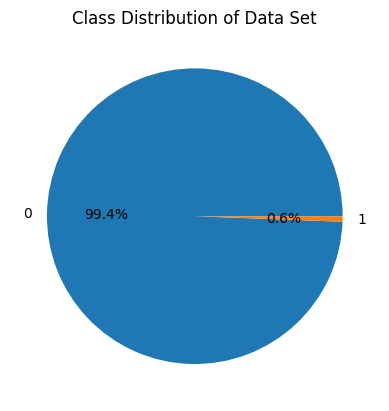

In [199]:
tot_y = y.value_counts()
plt.pie(tot_y.values, labels=tot_y.index.values, autopct='%1.1f%%')
plt.title("Class Distribution of Data Set")
plt.show()

As we can see, there is extreme imbalance for our prediction label (1 for player won player of the week award for that week, 0 otherwise). This is natural given that player of the week is highly selective, only two are given per week. Given this imbalance, we are highly at risk of our model predicting 0 for all future players. We will take measures to correct this balance as much as possible.

In [200]:
# 1. Statify ensures equal balance of y class. This ensures that even with the class imbalance, we retain that imbalance throughout our test and training data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RS, stratify=y)

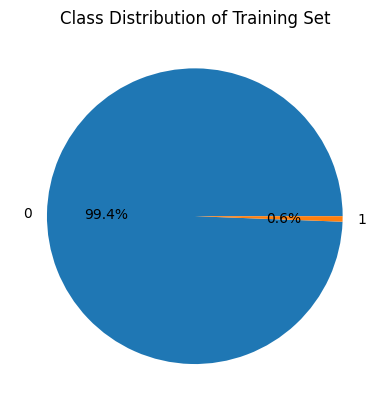

In [201]:
tot_y_tr = y_train.value_counts()
plt.pie(tot_y_tr.values, labels=tot_y_tr.index.values, autopct='%1.1f%%')
plt.title("Class Distribution of Training Set")
plt.show()

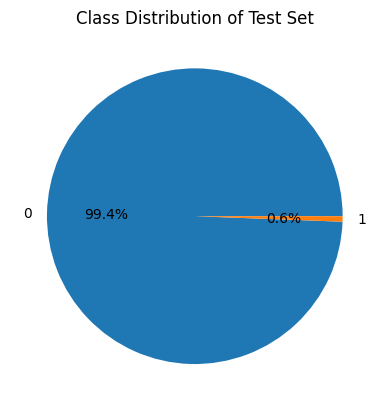

In [202]:
tot_y_te = y_test.value_counts()
plt.pie(tot_y_te.values, labels=tot_y_te.index.values, autopct='%1.1f%%')
plt.title("Class Distribution of Test Set")
plt.show()

In [203]:
# 2. We will use scale_pos_weight. Using this ratio, we will force our model to pay way more attention to our positive/1-label data rows
num_pos = y_train.sum()
num_neg = len(y_train) - num_pos
scale_pos_weight = num_neg / num_pos

In [204]:
# 3. Set learning rate low and number of estimators high. Since we have small signal, we need more boosting rounds to handle the class imbalance.
params = {
    "objective" :"binary",
    "n_estimators" :2000,
    "learning_rate":0.01,
    "max_depth":-1,
    "num_leaves":31,
    "subsample":0.8,
    "colsample_bytree":0.8,
    "scale_pos_weight":scale_pos_weight,
    "random_state":RS,
    "n_jobs":-1
}


# Model Selection

We will begin to test which Light GBM model is best for predicting winners. We will be using StratifiedKFold to ensure our cross validation folds are stratified, addressing the class imbalance and prevent overfitting results

In [205]:
# Cross fold validation to test model selection for LightGBM with stratifiedkfold, ensures each fold is stratified. 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RS)

fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    #obtain train imbalance ratio
    pos = y_tr.sum()
    neg = len(y_tr) - pos
    ratio = neg / pos

    model = lgb.LGBMClassifier(
        objective="binary",
        n_estimators=2000,
        learning_rate=0.01,
        max_depth=-1,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=ratio,
        random_state=RS,
        n_jobs=-1,
        verbose=-1 
    )

    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric="average_precision",
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)], #stops splitting if no more gain possible
        categorical_feature=cat_cols, #cat_cols = team, conference
    )

    y_val_proba = model.predict_proba(X_val)[:, 1]
    y_val_pred = (y_val_proba >= 0.5).astype(int)

    avg_prec = average_precision_score(y_val, y_val_pred)
    roc = roc_auc_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)

    fold_results.append(
        {"fold": fold, "average_precision": avg_prec, "roc_auc": roc, "f1": f1}
    )


In [206]:
# Results
cv_df = pd.DataFrame(fold_results)
print(cv_df)
print("\nMean over folds:")
print(cv_df[["average_precision", "roc_auc", "f1"]].mean())

   fold  average_precision  roc_auc   f1
0     1           0.005956      0.5  0.0
1     2           0.005956      0.5  0.0
2     3           0.005956      0.5  0.0
3     4           0.005956      0.5  0.0
4     5           0.005956      0.5  0.0

Mean over folds:
average_precision    0.005956
roc_auc              0.500000
f1                   0.000000
dtype: float64


The results show our model is very bad. F1 = 0, the model never predicted a "1" class. ROC = 0.5, model is basically a coin flip. Even with the use of scale_pos_weight and stratified splitting, our model is being heavily affected by the class imbalance. Lastly, the averge precisions is around the base rate, 0.006, the percentage of "1"-label rows from our data set (see pie chart above)

We could adjust parameters or lower the threshold for predicting a "1" class (currently at 0.5). Instead, lets focus on give a top-k prediction, where we output the top-k probabilities for a given week. Lets also check in this run if the model is splitting at all.

In [207]:
k = [1, 3, 5, 10] #Top k probabilities
hit_results = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
    k_dict = {i: [] for i in k}

    #obtain train imbalance ratio
    pos = y_tr.sum()
    neg = len(y_tr) - pos
    ratio = neg / pos

    model = lgb.LGBMClassifier(
        objective="binary",
        n_estimators=2000,
        learning_rate=0.01,
        max_depth=-1,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=ratio,
        random_state=RS,
        n_jobs=-1,
        verbose=-1
    )

    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric="average_precision",
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)],
        categorical_feature=cat_cols, #cat_cols = team, conference
    )

    y_val_proba = model.predict_proba(X_val)[:, 1]

    # Predicting if top-k probabilites is a "hit" i.e. 1-label
    df = X_val[['season', 'week', 'conference']].copy()
    df['y_true'] = y_val.values
    df['y_proba'] = y_val_proba
    
    groups = df.groupby(['season', 'week', 'conference'], observed=True)
    ranks = []
    for _, group in groups:
        if group['y_true'].sum() == 0:
            continue 
        group_sorted = group.sort_values('y_proba', ascending=False).reset_index(drop=True)
        pos_idx = group_sorted.index[group_sorted['y_true'] == 1]
        for i in k:
            top_k = group_sorted.head(i)
            hit = top_k['y_true'].max()
            k_dict[i].append(hit)
        for idx in pos_idx:
            ranks.append(idx + 1)
    ranks = np.array(ranks)
    curr = {"Fold": fold, "N_Unique_Prob": len(np.unique(y_val_proba)), "Max_Prob": y_val_proba.max(), "Min_Prob": y_val_proba.min(),
            "Num_winners_seen": len(ranks), "Top_rank": ranks.min(), "Lowest_rank": ranks.max(), "Percentiles": np.percentile(ranks, [10, 25, 50, 75, 90])
            }
    for i, hits in k_dict.items():
        curr[f"Top_{i}_avg_hits"] = np.mean(hits)
    hit_results.append(curr)



In [208]:
top_k_df = pd.DataFrame(hit_results)
top_k_df

,Fold,N_Unique_Prob,Max_Prob,Min_Prob,Num_winners_seen,Top_rank,Lowest_rank,Percentiles,Top_1_avg_hits,Top_3_avg_hits,Top_5_avg_hits,Top_10_avg_hits
0,1,8441,0.217893,0.005490,278,1,22,"[1.0, 1.0, 1.0, 2.0, 3.0]",0.672662,0.928058,0.978417,0.996403
1,2,5108,0.146508,0.005547,278,1,45,"[1.0, 1.0, 1.0, 2.0, 3.0]",0.694545,0.927273,0.963636,0.981818
2,3,5472,0.149141,0.005493,278,1,19,"[1.0, 1.0, 1.0, 2.0, 3.0]",0.616788,0.916058,0.981752,0.996350
3,4,5001,0.228617,0.005552,278,1,24,"[1.0, 1.0, 1.0, 2.0, 3.0]",0.638989,0.920578,0.978339,0.996390
4,5,8348,0.148150,0.005436,278,1,11,"[1.0, 1.0, 1.0, 2.0, 3.0]",0.654676,0.902878,0.967626,0.992806


In this model, we checked to see if we did correctly predict a winner from our top-k (1, 3, 5, 10) predictions per week, season, and conference. We first see our average "hit" (correct guess within our k-group) increases as k increases which is a good sign. We also see that we are splitting in our tree model as our number of unique probabilities > 1. While our model accuracy is great, reaching up to 99% accuracy when looking at the top 10 ranks, our rank range is from 1-45 across folds, meaning in some cases, we correctly rank a winner as the top rank while in other cases, we ranked a winner as low as 45th. Since we want to utilize this model on a week by week basis, we should improve our lower bound on rank prediction i.e. tighten our correct prediction rank window.

Let us instead change our model from binary to a ranking objective that ranks per group (season, week, conference). This is because our previous models treated each row independent, where in actuality, a winner is determined by the performance for that specific week, against players in their conference. By doing this, we are not vunerable to our class imbalance because each group has a winner and our model's objective is to rank our winner above all non-winners.

In [209]:
k = [1, 3, 5, 10]
fold_results = []
importance = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
    X_tr, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
    y_tr, y_val = y.iloc[train_idx].copy(), y.iloc[val_idx].copy()

    #Create grouping key for our folds.
    X_tr['key'] = X_tr['season'].astype(str) + X_tr['week'].astype(str) + X_tr['conference'].astype(str)
    X_val['key'] = X_val['season'].astype(str) + X_val['week'].astype(str) + X_val['conference'].astype(str)

    X_tr = X_tr.sort_values(by='key')
    y_tr = y_tr.loc[X_tr.index]

    X_val = X_val.sort_values(by='key')
    y_val = y_val.loc[X_val.index]

    #Obtain group sizes/starting index
    tr_group_sizes = X_tr.groupby('key').size().to_numpy()
    val_group_sizes = X_val.groupby('key').size().to_numpy()

    model = lgb.LGBMRanker(
        objective="lambdarank",
        metric="ndcg", #scores based on predicted rank of winners
        n_estimators=2000,
        learning_rate=0.05,
        num_leaves=31,
        random_state=RS,
        n_jobs=-1,
        verbose=-1 
    ) #No longer need to address the class imbalance

    model.fit(
    X_tr.drop(columns=['key']),
    y_tr,
    group=tr_group_sizes, # groups based on sizing key
    eval_set=[(X_val.drop(columns=['key']), y_val)],
    eval_group=[val_group_sizes], # groups based on sizing key
    eval_at=[1,3,5,10], #thresholds for scoring
    categorical_feature=cat_cols,
    callbacks=[lgb.early_stopping(100, verbose=False)],
    )

    y_val_score = model.predict(X_val.drop(columns=['key']))

    df_val = X_val[["season", "week", "conference"]].copy()
    df_val["y_true"] = y_val.values
    df_val["score"] = y_val_score

    hits = {i: [] for i in k}
    ranks = []
    for _, group in df_val.groupby(['season', 'week', 'conference'], observed=True):
        if group['y_true'].sum() == 0:
            continue  
        group_sorted = group.sort_values(by='score', ascending=False).reset_index(drop=True)
        for i in k:
            top_k = group_sorted.head(i)
            hit = top_k['y_true'].max()
            hits[i].append(hit)
        pos_idx = group_sorted.index[group_sorted['y_true'] == 1]
        for idx in pos_idx:
            ranks.append(idx + 1)
    avg_hits = {i: float(np.mean(value)) for i, value in hits.items()}
    ranks = np.array(ranks)
    fold_results.append(
        {"fold": fold, "Top_1_avg_hits": avg_hits[1], "Top_3_avg_hits": avg_hits[3], "Top_5_avg_hits": avg_hits[5],
         "Top_10_avg_hits": avg_hits[10], "Top_rank": ranks.min(), "Lowest_rank": ranks.max(), 
         "Percentiles": np.percentile(ranks, [10, 25, 50, 75, 90])}
    )

    importance.append(model.booster_.feature_importance(importance_type="gain"))

mean_importance = np.mean(importance, axis=0)

feat_imp = pd.DataFrame({
    "feature": model.booster_.feature_name(),
    "importance": mean_importance
}).sort_values("importance", ascending=False)

top_k_rank_df = pd.DataFrame(fold_results)



In [210]:
top_k_rank_df

,fold,Top_1_avg_hits,Top_3_avg_hits,Top_5_avg_hits,Top_10_avg_hits,Top_rank,Lowest_rank,Percentiles
0,1,0.830935,0.964029,0.989209,0.996403,1,15,"[1.0, 1.0, 1.0, 1.0, 2.0]"
1,2,0.789091,0.960000,0.981818,0.992727,1,25,"[1.0, 1.0, 1.0, 1.0, 2.3000000000000114]"
2,3,0.795620,0.981752,0.992701,1.000000,1,10,"[1.0, 1.0, 1.0, 1.0, 2.0]"
3,4,0.848375,0.981949,0.992780,1.000000,1,8,"[1.0, 1.0, 1.0, 1.0, 2.0]"
4,5,0.802158,0.960432,0.992806,0.996403,1,12,"[1.0, 1.0, 1.0, 1.0, 2.0]"


By changing our model objective, we have greatly improved our average "hit" accuracy, with some folds correctly predicting the winner in their top-10 rank per group. Furthermore, we see that we have greatly reduced our lower bound ranking window from 45 to 25. When looking at our ranking percentile, we see that at least 75% of our predictions correctly rank the winner as the top rank as evident in our Top_1_avg_hits. For our 90th percentile, we our ranking the correct winner in our top 2 ranks. This is a great indicator as if our first choice is wrong, our second choice is the correct winner for 90% of our per group predictions across all folds.

# Model Tuning

Now that we have a selected a good model set up, we can now focus on parameter tuning to increase our accuracy. We will use optuna for its flexibility and reward based tuning system. We also focus on our top-1 hits since we already achieve high hit accuracy for k > 1.

In [211]:
import optuna

In [212]:
def objective(trial):
    params = {
        "objective": "lambdarank",
        "metric": "ndcg",
        "n_estimators": 3000, #Since we have early stopage, we don't need to test number of estimators
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.08),
        "num_leaves": trial.suggest_int("num_leaves", 31, 127),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 200),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-3, 10.0, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-3, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-3, 10.0, log=True),
        "random_state": RS,
        "n_jobs": -1,
        "verbose": -1,
    }

    k = [1, 3, 5, 10]
    fold_results = []
    for _, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
        X_tr, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
        y_tr, y_val = y.iloc[train_idx].copy(), y.iloc[val_idx].copy()

        #Create grouping key for our folds.
        X_tr['key'] = X_tr['season'].astype(str) + X_tr['week'].astype(str) + X_tr['conference'].astype(str)
        X_val['key'] = X_val['season'].astype(str) + X_val['week'].astype(str) + X_val['conference'].astype(str)

        X_tr = X_tr.sort_values(by='key')
        y_tr = y_tr.loc[X_tr.index]

        X_val = X_val.sort_values(by='key')
        y_val = y_val.loc[X_val.index]

        #Obtain group sizes/starting index
        tr_group_sizes = X_tr.groupby('key').size().to_numpy()
        val_group_sizes = X_val.groupby('key').size().to_numpy()

        model = lgb.LGBMRanker(**params)

        model.fit(
        X_tr.drop(columns=['key']),
        y_tr,
        group=tr_group_sizes, # groups based on sizing key
        eval_set=[(X_val.drop(columns=['key']), y_val)],
        eval_group=[val_group_sizes], # groups based on sizing key
        eval_at=[1,3,5,10], #thresholds for scoring
        categorical_feature=cat_cols,
        callbacks=[lgb.early_stopping(100, verbose=False)],
        )

        y_val_score = model.predict(X_val.drop(columns=['key']))

        df_val = X_val[["season", "week", "conference"]].copy()
        df_val["y_true"] = y_val.values
        df_val["score"] = y_val_score

        hits_1st = []
        for _, group in df_val.groupby(['season', 'week', 'conference'], observed=True):
            if group['y_true'].sum() == 0:
                continue  
            group_sorted = group.sort_values(by='score', ascending=False)
            hit = group_sorted.head(1)['y_true'].max()
            hits_1st.append(hit)
        
        if len(hits_1st) != 0:
            fold_results.append(np.mean(hits_1st))
        

    if len(fold_results) == 0:
        return 0.0
    return np.mean(fold_results)



In [213]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
print("Top accuracy:", study.best_value)
print("Best params:", study.best_params)

[I 2025-11-25 18:12:22,119] A new study created in memory with name: no-name-27a8b083-6a95-4cec-934b-74bb17ac1f2f
[I 2025-11-25 18:12:43,786] Trial 0 finished with value: 0.8031824726521453 and parameters: {'learning_rate': 0.02348181055528282, 'num_leaves': 61, 'min_child_samples': 49, 'min_child_weight': 0.10481472027714431, 'feature_fraction': 0.8213797942874079, 'bagging_fraction': 0.748218934830116, 'bagging_freq': 10, 'lambda_l1': 0.8269382076123039, 'lambda_l2': 0.0016066649198121224}. Best is trial 0 with value: 0.8031824726521453.
[I 2025-11-25 18:13:01,968] Trial 1 finished with value: 0.8197973874302852 and parameters: {'learning_rate': 0.02528580406792215, 'num_leaves': 35, 'min_child_samples': 174, 'min_child_weight': 0.004045696659696315, 'feature_fraction': 0.9770916799890783, 'bagging_fraction': 0.6670670923778261, 'bagging_freq': 9, 'lambda_l1': 0.005826946976112512, 'lambda_l2': 0.0010488398082580971}. Best is trial 1 with value: 0.8197973874302852.
[I 2025-11-25 18:1

Top accuracy: 0.8277846314029149
Best params: {'learning_rate': 0.04224899106752549, 'num_leaves': 111, 'min_child_samples': 165, 'min_child_weight': 0.19946349433261187, 'feature_fraction': 0.950459298351026, 'bagging_fraction': 0.9265657728640747, 'bagging_freq': 4, 'lambda_l1': 0.28365761694442293, 'lambda_l2': 0.3877946360979252}


From our optuna trials, we see that we are averaging around 82% top-1 rank prediction accuracy. There is no substantial gain from parameter tuning. We can go back and change the range of parameter values. But given that our accuracy increases as k increases, this 82% baseline is a good start. We will move on to training our final model using the best parameters from our trials.

In [214]:
best_params = study.best_params
best_params.update({
    "objective": "lambdarank",
    "metric": "ndcg",
    "n_estimators": 2000
})
print(best_params)

{'learning_rate': 0.04224899106752549, 'num_leaves': 111, 'min_child_samples': 165, 'min_child_weight': 0.19946349433261187, 'feature_fraction': 0.950459298351026, 'bagging_fraction': 0.9265657728640747, 'bagging_freq': 4, 'lambda_l1': 0.28365761694442293, 'lambda_l2': 0.3877946360979252, 'objective': 'lambdarank', 'metric': 'ndcg', 'n_estimators': 2000}


In [215]:
#from our previous cells in EDA
X['key'] = X['season'].astype(str) + X['week'].astype(str) + X['conference'].astype(str)
unique_keys = X['key'].unique()

train_keys, test_keys = train_test_split(unique_keys, test_size=0.2, random_state=RS)
X_train, y_train = X[X['key'].isin(train_keys)].copy(), y[X['key'].isin(train_keys)].copy()
X_test, y_test = X[X['key'].isin(test_keys)].copy(), y[X['key'].isin(test_keys)].copy()

X_train = X_train.sort_values(by='key')
y_train = y_train.loc[X_train.index]

X_test = X_test.sort_values(by='key')
y_test = y_test.loc[X_test.index]

train_groups = X_train.groupby('key').size().to_numpy()
test_groups = X_test.groupby('key').size().to_numpy()

final_model = lgb.LGBMRanker(**best_params)

final_model.fit(
    X_train.drop(columns=['key']),
    y_train,
    group=train_groups,
    categorical_feature=cat_cols
)

k = [1, 3, 5, 10]

y_test_score = model.predict(X_test.drop(columns=["key"]))


df_test = X_test[["season", "week", "conference"]].copy()
df_test["y_true"] = y_test.values
df_test["score"] = y_test_score

hits = {i: [] for i in k}
ranks = []

for _, group in df_test.groupby(["season", "week", "conference"], observed=True):
    if group["y_true"].sum() == 0: #shouldn't be necessary since we split by key
        continue

    group_sorted = group.sort_values("score", ascending=False).reset_index(drop=True)

    for i in k:
        hit = group_sorted.head(i)["y_true"].max()
        hits[i].append(hit)

    pos_idx = group_sorted.index[group_sorted["y_true"] == 1]
    for idx in pos_idx:
        ranks.append(idx + 1)
ranks = np.array(ranks)
percentiles = [10, 25, 50, 75, 90]
rank_percentiles = np.percentile(ranks, percentiles)
results = {
    "Num_winners": len(ranks),
    "Best_rank": int(ranks.min()),
    "Worst_rank": int(ranks.max())
}
for i, p in enumerate(percentiles):
    results[f'Rank_{p}_perc'] = rank_percentiles[i]
for i, v in hits.items():
    results[f"Top_{i}_hit_rate"] = float(np.mean(v))

final_results = pd.DataFrame([results])

feat_imp = pd.DataFrame({
    "feature": model.booster_.feature_name(),
    "importance": model.booster_.feature_importance(importance_type="gain")
}).sort_values("importance", ascending=False)



In [216]:
final_results

,Num_winners,Best_rank,Worst_rank,Rank_10_perc,Rank_25_perc,Rank_50_perc,Rank_75_perc,Rank_90_perc,Top_1_hit_rate,Top_3_hit_rate,Top_5_hit_rate,Top_10_hit_rate
0,279,1,10,1.0,1.0,1.0,1.0,2.0,0.893382,0.970588,0.985294,1.0


In [217]:
feat_imp.head(10)

,feature,importance
6,points,89182.891396
22,wins_this_week,9782.911696
0,team,7139.355498
38,team_pts,7007.693269
14,fieldGoalsMade,4015.957121
43,fieldGoalsPercentage,3122.196521
21,plusMinusPoints,2747.906333
7,assists,2444.143481
10,reboundsTotal,2369.181286
42,team_gms,2334.323592


# Final Results

With our final model that utilizes an ranking objective, trained and tested on data split by groups (season, week, conference), and optimal parameters from our optuna trials, we achieve 89% accuracy on predicting the correct player of the week winner. Our model also always ranks the winner within the top 10 spots. Again, for 90% of our predictions, if our model incorrectly predicted the winner, the correct winner had the second highest rank. This is a great performance. We see that our features provide strong indication of a player winning player of the week. To increase our model's accuracy even more, we can provide more features or continue to adjust our parameters when tuning.